In [103]:
import pandas as pd
import numpy as np
import json
import os
directory = 'data/ipl_json'
name_and_seasons = set()
for filename in os.listdir(directory):
    f = os.path.join(directory, filename)
    if os.path.isfile(f) and '.json' in f:
        jsonFile = json.load(open(f))
        for team in jsonFile['info']['players']:
            for player in jsonFile['info']['players'][team]:
                name_and_seasons.add((player, str(jsonFile['info']['season'])))

players = pd.DataFrame()
players['name'] = [name_and_season[0] for name_and_season in name_and_seasons]
players['season'] = [name_and_season[1] for name_and_season in name_and_seasons]
runList = {}
ballList = {}
for filename in os.listdir(directory):
    f = os.path.join(directory, filename)
    if os.path.isfile(f) and '.json' in f:
        jsonFile = json.load(open(f))
        season = str(jsonFile['info']['season'])
        for inning in jsonFile['innings']:
            for over in inning['overs']:
                for delivery in over['deliveries']:
                    batter = delivery['batter']
                    runs = delivery['runs']['batter']
                    ballFaced = 0
                    try:
                        if not 'wides' in delivery['extras']:
                            ballFaced = 1
                    except:
                        ballFaced = 1
                    if (batter, season) in runList:
                        runList[(batter, season)] += runs
                        ballList[(batter, season)] += ballFaced
                    else:
                        ballList[(batter, season)] = ballFaced
                        runList[(batter, season)] = runs


players['R'] = players.set_index(['name', 'season']).index.map(runList.get)
players['B'] = players.set_index(['name', 'season']).index.map(ballList.get)
players['SR'] = round(players['R'] / players['B'] * 100, 2)

players = players.fillna(0)

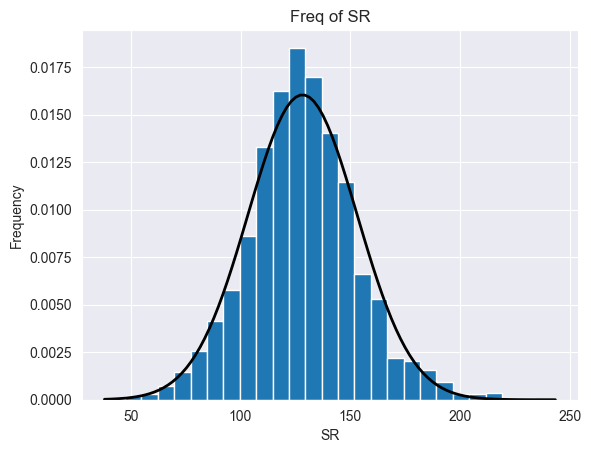

,name,season,R,B,SR
346,J Fraser-McGurk,2024,330.0,141.0,234.04
1736,MS Dhoni,2024,161.0,73.0,220.55
1421,CR Brathwaite,2016,83.0,38.0,218.42
1703,Rashid Khan,2023,130.0,60.0,216.67
156,TH David,2022,186.0,86.0,216.28
...,...,...,...,...,...
958,PC Valthaty,2012,30.0,51.0,58.82
73,Anureet Singh,2015,18.0,31.0,58.06
1820,VVS Laxman,2009,19.0,33.0,57.58
1273,V Shankar,2022,19.0,35.0,54.29


In [104]:
import matplotlib.pyplot as plt
from scipy.stats import norm

data = players[players['B'] > 30]['SR']
plt.hist(data, bins = 25, density = True)


mu, std = norm.fit(data)

# Create a range for the x-axis
xmin, xmax = plt.xlim()
x = np.linspace(xmin, xmax, 100)

# Scale the PDF to match the histogram
pdf_scaled = norm.pdf(x, mu, std)

# Plot the scaled PDF
plt.plot(x, pdf_scaled, 'k', linewidth=2)

# Add labels
plt.title('Freq of SR')
plt.xlabel('SR')
plt.ylabel('Frequency')

plt.show()
display(players[players['B'] > 30].sort_values(by = ['SR'], ascending = False))

In [105]:
over = []
wickets_left = []
batter_runs = []
total_runs = []
batter = []
bowler = []
season_list = []


for filename in os.listdir(directory):
    f = os.path.join(directory, filename)
    if os.path.isfile(f) and '.json' in f:
        jsonFile = json.load(open(f))
        season = str(jsonFile['info']['season'])
        for inning in jsonFile['innings']:
            current_wickets_left = 10
            for o in inning['overs']:
                current_over = o['over']
                for delivery in o['deliveries']:
                    over.append(current_over)
                    wickets_left.append(current_wickets_left)
                    batter_runs.append(delivery['runs']['batter'])
                    total_runs.append(delivery['runs']['total'])
                    batter.append(delivery['batter'])
                    bowler.append(delivery['bowler'])
                    season_list.append(season)
                    if 'wickets' in delivery:
                        current_wickets_left -= len(delivery['wickets'])

runs = pd.DataFrame()
runs['over'] = over
runs['wickets_left'] = wickets_left
runs['batter_runs'] = batter_runs
runs['total_runs'] = total_runs
runs['batter'] = batter
runs['bowler'] = bowler
runs['season'] = season_list
runs

,over,wickets_left,batter_runs,total_runs,batter,bowler,season
0,0,10,0,0,TM Head,K Rabada,2024
1,0,10,0,0,TM Head,K Rabada,2024
2,0,10,4,4,TM Head,K Rabada,2024
3,0,10,0,0,TM Head,K Rabada,2024
4,0,10,0,0,TM Head,K Rabada,2024
...,...,...,...,...,...,...,...
260915,19,7,2,2,YK Pathan,DT Christian,2018
260916,19,7,6,6,YK Pathan,DT Christian,2018
260917,19,7,4,4,YK Pathan,DT Christian,2018
260918,19,7,1,1,YK Pathan,DT Christian,2018


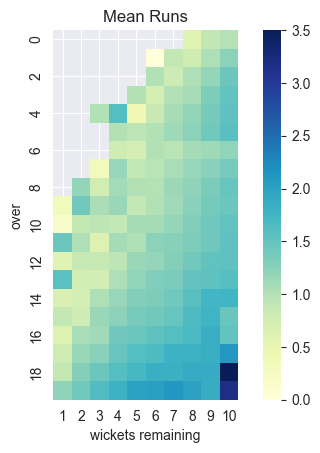

39


In [106]:
import seaborn as sns

mat = np.empty((20, 10))
for over in range(20):
    for wickets_left in range(10):
        if len(runs[(runs['over'] == over) & (runs['wickets_left'] == wickets_left + 1)]) > 0:
            mat[over, wickets_left] = runs[(runs['over'] == over) & (runs['wickets_left'] == wickets_left + 1)]['total_runs'].mean()
        else:
            mat[over, wickets_left] = np.NaN


data = pd.DataFrame(mat)
data.columns = range(1, 11)
data = data.rename_axis('over', axis=0).rename_axis('wickets remaining', axis=1)

ax = sns.heatmap(data, fmt=".2f", cmap="YlGnBu", square = True)
plt.xticks(np.arange(0.5, 10.5, 1), np.arange(1, 11, 1))
plt.yticks(np.arange(0.5, 20.5, 2), np.arange(0, 20, 2))
plt.title('Mean Runs')

# Show the plot
plt.show()
print(len(runs[(runs['over'] == 13) & (runs['wickets_left'] == 0 + 1)]))

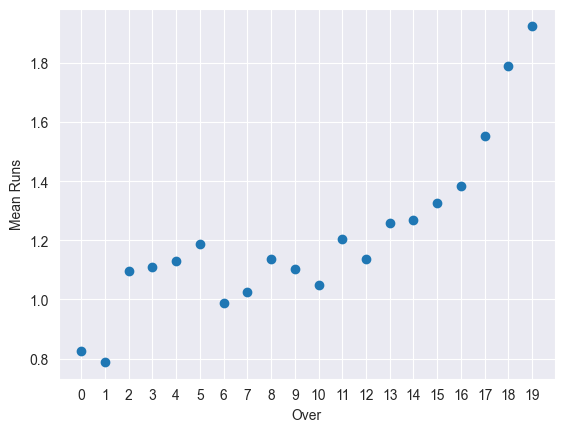

In [107]:
new_data = data
new_data['mean_runs'] = new_data.mean(axis=1)
plt.xticks(np.arange(0, 20, 1), np.arange(0, 20, 1))
plt.xlabel("Over")
plt.ylabel("Mean Runs")
plt.scatter(new_data.index, new_data["mean_runs"])

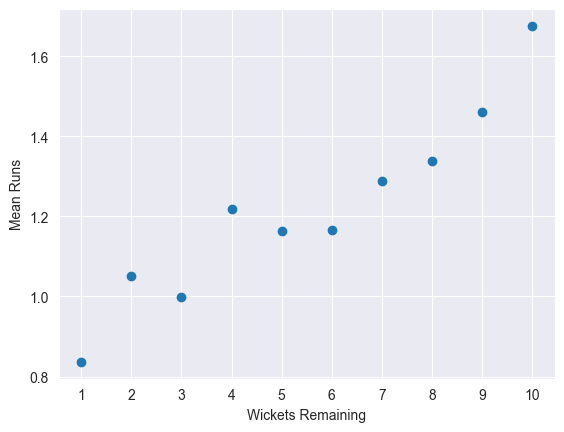

In [108]:
new_data = data
new_data['mean_runs'] = new_data.mean(axis=0)
plt.xticks(np.arange(0, 20, 1), np.arange(0, 20, 1))
plt.xlabel("Wickets Remaining")
plt.ylabel("Mean Runs")
plt.scatter(new_data.index, new_data["mean_runs"])

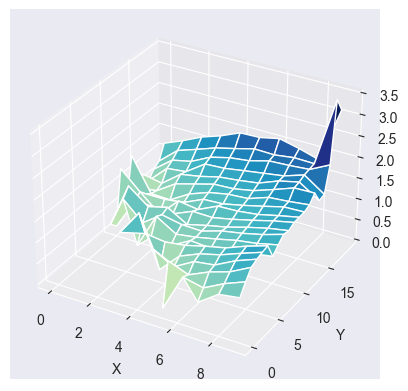

In [109]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Example 2D numpy matrix
matrix = mat  # Replace this with your matrix

# Create meshgrid for the X and Y coordinates
x = np.arange(matrix.shape[1])
y = np.arange(matrix.shape[0])
X, Y = np.meshgrid(x, y)

# Create the figure and axis
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# Plot the surface
ax.plot_surface(X, Y, matrix, cmap='YlGnBu')

# Add labels
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')

plt.show()

In [110]:
expectancy_matrix = data.to_numpy()
expectancy_matrix

array([[       nan,        nan,        nan,        nan,        nan,
               nan,        nan, 0.57777778, 0.91579943, 0.98851921,
               nan],
       [       nan,        nan,        nan,        nan,        nan,
        0.        , 0.88888889, 0.78695652, 1.03770437, 1.23124028,
        0.83663262],
       [       nan,        nan,        nan,        nan,        nan,
        1.        , 0.82010582, 1.03548086, 1.18827709, 1.44111623,
        1.05242663],
       [       nan,        nan,        nan,        nan, 1.        ,
        0.73529412, 1.00886918, 1.07628979, 1.3227704 , 1.50578956,
        0.99767442],
       [       nan,        nan, 1.        , 1.6       , 0.4       ,
        0.86910995, 1.06971154, 1.19290888, 1.37456157, 1.54445934,
        1.21826674],
       [       nan,        nan,        nan, 1.        , 0.94230769,
        1.0052356 , 1.12950192, 1.23540036, 1.42080808, 1.57549612,
        1.16269089],
       [       nan,        nan,        nan, 0.7826087 , 0.

In [118]:
expected_runs_per_play = []
runs['expected_runs'] = runs.apply((lambda row: expectancy_matrix[row['over']][row['wickets_left'] - 1]), axis = 1)
runs['runs_above_average'] = runs['total_runs'] - runs['expected_runs']

In [143]:
TR_above_average_batter = runs.groupby(['batter', 'season'])['runs_above_average'].mean() * runs.groupby(['batter', 'season']).size()
TR_above_average_batter.to_frame()
TR_above_average_batter.sort_values(ascending=False)

batter           season
Abhishek Sharma  2024      194.406469
TM Head          2024      188.958050
GJ Maxwell       2014      183.759447
RR Pant          2018      180.216151
SA Yadav         2023      172.440828
                              ...    
JH Kallis        2013      -94.181721
GH Vihari        2013     -112.782347
JH Kallis        2012     -112.802200
AT Rayudu        2019     -115.951896
AM Rahane        2013     -138.435506
Length: 2617, dtype: float64

In [142]:
TR_above_average_bowler = -1 * runs.groupby(['bowler', 'season'])['runs_above_average'].mean() * runs.groupby(['bowler', 'season']).size()
TR_above_average_bowler.to_frame()
TR_above_average_bowler.sort_values(ascending=False)

bowler          season 
SP Narine       2013       210.088479
                2012       195.726810
DW Steyn        2013       152.786484
SP Narine       2014       144.987788
Rashid Khan     2020/21    139.149513
                              ...    
B Kumar         2024       -90.910489
A Nortje        2024       -94.141701
Mohammed Siraj  2022       -96.895305
HH Pandya       2024      -102.613754
MA Starc        2024      -129.063861
Length: 1948, dtype: float64

In [115]:
average_values = runs.groupby('batter')['runs_above_average'].mean()
grouped_counts = runs.groupby('batter').size()

In [116]:
print(average_values['RR Pant'])
print(grouped_counts['RR Pant'])

0.17593750547192982
2296
